In [ ]:
# !pip install tensorflow
# !pip install pandas
# !pip install matplotlib
# !python -m pip install numpy scipy matplotlib ipython jupyter pandas sympy nose

In [1]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import os, datetime, random
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# memory 관련 이슈를 해결하기 위한 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# set random seed
# np.random.seed(42)
random.seed(12345)
tf.random.set_seed(42)

In [4]:
# 사전 설정을 위한 세팅
epochs = 256
image_size = 256
batch = 32

# Directory check
logdir = '../logs'
if not os.path.isdir(logdir):
    os.mkdir(logdir)
    os.mkdir(logdir + "/disease")
    os.mkdir(logdir + "/plant")

In [11]:
# Read dataframe from tsv file
train_df = pd.read_csv("../data/train/train.tsv", sep='\t', header=None)
train_df.columns = ['filename', 'plant', 'disease']

test_df = pd.read_csv("../data/test/test.tsv", sep='\t', header=None)
test_df.columns = ['filename']

# for categorical labels
train_df[['plant', 'disease']] = train_df[['plant', 'disease']].astype(str)

In [12]:
# declare image generator
train_image_generator = ImageDataGenerator(rotation_range=5, horizontal_flip=True, validation_split=0.25) # Generator for our training, validation data
test_image_generator = ImageDataGenerator() # Generator for our test data

In [13]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_df,
                                                           directory="../data/train",
                                                           x_col="filename",
                                                           y_col="plant",
                                                           class_mode="categorical",
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(image_size,image_size),
                                                           batch_size=batch)

valid_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_df,
                                                           directory="../data/train",
                                                           x_col="filename",
                                                           y_col="plant",
                                                           class_mode="categorical",
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(image_size,image_size),
                                                           batch_size=batch)

test_data_gen = test_image_generator.flow_from_dataframe(dataframe=test_df,
                                                         directory="../data/test",
                                                         x_col="filename",
                                                         y_col=None,
                                                         class_mode=None,
                                                         shuffle=False,
                                                         target_size=(image_size,image_size),
                                                         batch_size=batch)

Found 12000 validated image filenames belonging to 8 classes.
Found 4000 validated image filenames belonging to 8 classes.
Found 3997 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


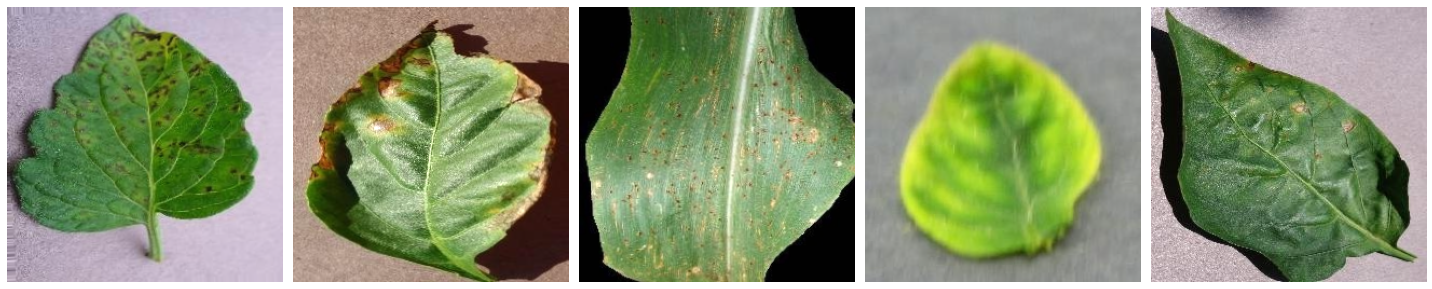

In [14]:
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img/225)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])



In [15]:
# Call bottom model
inputs = Input(shape = (image_size, image_size, 3))
bot_model = EfficientNetB2(weights='imagenet', input_tensor=inputs, classifier_activation=None, include_top=False)
# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(bot_model.output)
x = BatchNormalization(name="bn_avg_pool")(x)
x = Dropout(0.5)(x)
x = Dense(176, activation="swish", name="top_dense_1")(x)
x = Dense(22, activation="relu", name="top_dense_2")(x)
outputs = Dense(8, activation="softmax", name="pred")(x)

In [16]:
# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
model.compile(optimizer=Adam(learning_rate=0.000002),
loss='categorical_crossentropy',
metrics=['accuracy'])
logdir = os.path.join("../logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [19]:
callbacks = [
    ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="../models/mymodel_best.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=1e-4,
        patience=16,
        verbose=1,
    ),
    TensorBoard(logdir, histogram_freq=1)
]

In [20]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=valid_data_gen,
    callbacks=callbacks,
)

Epoch 1/256
375/375 [==============================] - ETA: 0s - loss: 2.0789 - accuracy: 0.4000
Epoch 00001: val_loss improved from inf to 2.07868, saving model to ../models\mymodel_best.h5


InvalidArgumentError: Nan in summary histogram for: stem_conv/kernel_0 [Op:WriteHistogramSummary]

In [ ]:
plant_pred = model.predict(test_data_gen)
test_df['plant'] = tf.math.argmax(plant_pred, 1)

In [ ]:
# declare image generator
train_disease_gen = train_image_generator.flow_from_dataframe(dataframe=train_df,
                                                           directory="../data/train",
                                                           x_col="filename",
                                                           y_col="disease",
                                                           class_mode="categorical",
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(image_size,image_size),
                                                           batch_size=batch)

valid_disease_gen = train_image_generator.flow_from_dataframe(dataframe=train_df,
                                                           directory="../data/train",
                                                           x_col="filename",
                                                           y_col="disease",
                                                           class_mode="categorical",
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(image_size,image_size),
                                                           batch_size=batch)

test_disease_gen = test_image_generator.flow_from_dataframe(dataframe=test_df,
                                                         directory="../data/test",
                                                         x_col="filename",
                                                         y_col=None,
                                                         class_mode=None,
                                                         shuffle=False,
                                                         target_size=(image_size,image_size),
                                                         batch_size=batch)

In [ ]:
# Call bottom model
inputs = Input(shape = (image_size, image_size, 3))
bot_model = EfficientNetB2(weights='imagenet', input_tensor=inputs, classifier_activation=None, include_top=False)
# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(bot_model.output)
x = BatchNormalization(name="bn_avg_pool")(x)
x = Dropout(0.5)(x)
x = Dense(176, activation="swish", name="top_dense_1")(x)
x = Dense(22, activation="relu", name="top_dense_2")(x)
outputs = Dense(14, activation="softmax", name="pred")(x)

In [ ]:
# Compile
disease_model = tf.keras.Model(inputs, outputs, name="EfficientNet")
disease_model.compile(optimizer=Adam(learning_rate=0.000002),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
logdir = os.path.join("../logs/disease", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
disease_model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="../model/disease_mymodel_best.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=1e-4,
        patience=16,
        verbose=1,
    ),
    TensorBoard(logdir, histogram_freq=1)
]

In [ ]:
history = disease_model.fit(
    train_disease_gen,
    epochs=epochs,
    validation_data=valid_disease_gen,
    callbacks=callbacks,
)

In [ ]:
disease_pred = disease_model.predict(test_disease_gen)
test_df['disease'] = tf.math.argmax(disease_pred, 1)

In [ ]:
test_df.to_csv("final_test_df.tsv", sep='\t', header = False, index=False)

In [ ]:
test_df = pd.read_csv("final_test_df.tsv", sep='\t')

In [ ]:
test_df = test_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [3]:
test_df

,filename,plant,disease
0,0.jpg,3,9
1,1.jpg,3,8
2,2.jpg,4,7
3,3.jpg,4,11
4,4.jpg,4,1
...,...,...,...
3992,3992.jpg,2,3
3993,3993.jpg,2,4
3994,3994.jpg,2,5
3995,3995.jpg,2,6
